In [1]:
import pandas as pd

df = pd.read_csv("C:\\PythonProjects\\PBL2\\cicids2017_cleaned.csv")
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,...,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Max,Active Min,Idle Mean,Idle Max,Idle Min,Attack Type
0,22,1266342,41,2664,456,0,64.975610,109.864573,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
1,22,1319353,41,2664,456,0,64.975610,109.864573,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
2,22,160,1,0,0,0,0.000000,0.000000,0,0,...,243,0,32,0.0,0,0,0.0,0,0,Normal Traffic
3,22,1303488,41,2728,456,0,66.536585,110.129945,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
4,35396,77,1,0,0,0,0.000000,0.000000,0,0,...,290,0,32,0.0,0,0,0.0,0,0,Normal Traffic


In [2]:
df['Attack Type'].value_counts()

Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Name: count, dtype: int64

In [4]:
X = df.drop(['Attack Type'], axis=1)
y = df['Attack Type']

In [5]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

undersample = RandomUnderSampler(sampling_strategy={  
    'Normal Traffic': 1500000,  # Reduce, but keep enough  
    'DoS': 193745,  # Keep as is  
    'DDoS': 128014,  
    'Port Scanning': 90694,  
    'Brute Force': 9150,  
    'Web Attacks': 2143,  
    'Bots': 1948  
}, random_state=42) 

X_train_resampled, y_train_resampled = undersample.fit_resample(X, y)

from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy={  
    'Web Attacks': 20000,  # Increase from 2K to 10K  
    'Bots': 20000,  
    'Brute Force': 40000  
}, random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_resampled, y_train_resampled)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_resampled),
    y=y_train_resampled
)
class_weight_dict = dict(zip(np.unique(y_train_resampled), class_weights))

In [6]:
print(pd.Series(y_train_resampled).value_counts())

Attack Type
Normal Traffic    1500000
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force         40000
Bots                20000
Web Attacks         20000
Name: count, dtype: int64


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [13]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels (string → integer)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_resampled)  # Train labels
y_val_encoded = label_encoder.transform(y)

In [15]:
import numpy as np

# Get unique class counts in train and validation sets
train_counts = np.bincount(y_train_encoded)
val_counts = np.bincount(y_val_encoded)

# Print label counts
print("Train Label Counts:")
for label, count in zip(np.unique(y_train_encoded), train_counts):
    print(f"  Class {label}: {count} samples")

print("\nValidation Label Counts:")
for label, count in zip(np.unique(y_val_encoded), val_counts):
    print(f"  Class {label}: {count} samples")

Train Label Counts:
  Class 0: 20000 samples
  Class 1: 40000 samples
  Class 2: 128014 samples
  Class 3: 193745 samples
  Class 4: 1500000 samples
  Class 5: 90694 samples
  Class 6: 20000 samples

Validation Label Counts:
  Class 0: 1948 samples
  Class 1: 9150 samples
  Class 2: 128014 samples
  Class 3: 193745 samples
  Class 4: 2095057 samples
  Class 5: 90694 samples
  Class 6: 2143 samples


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert training data (balanced dataset)
X_train_tensor = torch.tensor(X_train_resampled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)

# Convert validation data (original dataset)
X_val_tensor = torch.tensor(X.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.long)

# Create DataLoaders
batch_size = 64 # <-- SET YOUR BATCH SIZE
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [40]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the CNN + BiLSTM model
class CNN_BiLSTM(nn.Module):
    def __init__(self, num_classes):
        super(CNN_BiLSTM, self).__init__()

        # 3 CNN Layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.1)

        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.1)

        self.conv3 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # BiLSTM Layer
        self.lstm = nn.LSTM(input_size=64, hidden_size=64, num_layers=1, batch_first=True, bidirectional=True)
        self.dropout3 = nn.Dropout(0.1)

        # Fully Connected Output Layer
        self.fc = nn.Linear(64 * 2, num_classes)  # BiLSTM is bidirectional (×2)

    def forward(self, x):
        x = x.unsqueeze(1)  # Change to (batch_size, 1, features) for CNN
        
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)

        x = self.relu(self.conv3(x))

        x = x.permute(0, 2, 1)  # Reshape for LSTM (batch, seq_len, features)
        x, _ = self.lstm(x)
        #x = self.dropout3(x)

        x = self.fc(x[:, -1, :])  # Use last time step from BiLSTM
        return x

In [41]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

num_classes = len(label_encoder.classes_)


# Define model, loss, optimizer
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to("cuda")

model = CNN_BiLSTM(num_classes).to("cuda")
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# LR Scheduler: Reduce LR if validation accuracy plateaus
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5, verbose=True)

In [42]:
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Early Stopping
patience = 5
best_val_acc = 0
epochs_no_improve = 0

num_epochs = 30  # Adjustable

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0

    # Training Loop with Progress Bar
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
    for X_batch, y_batch in loop:
        X_batch, y_batch = X_batch.to("cuda"), y_batch.to("cuda")

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += y_batch.size(0)
        train_correct += (predicted == y_batch).sum().item()

        # Update progress bar
        loop.set_postfix(train_loss=loss.item())

    train_acc = train_correct / train_total * 100
    avg_train_loss = train_loss / len(train_loader)

    # Validation Step
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to("cuda"), y_batch.to("cuda")
            outputs = model(X_batch)

            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_total += y_batch.size(0)
            val_correct += (predicted == y_batch).sum().item()

    val_acc = val_correct / val_total * 100
    avg_val_loss = val_loss / len(val_loader)

    # Print Epoch Summary
    print(f"Epoch [{epoch+1}/{num_epochs}] → "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Update LR if validation accuracy plateaus
    scheduler.step(val_acc)

    # Early Stopping Check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0  # Reset counter
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("⏹️ Early stopping triggered! Stopping training.")
        break

print(f"🏆 Best Validation Accuracy: {best_val_acc:.2f}%")

Epoch 1/30: 100%|██████████| 31133/31133 [03:21<00:00, 154.17it/s, train_loss=0.184] 


Epoch [1/30] → Train Loss: 0.5952, Train Acc: 66.05% | Val Loss: 0.7530, Val Acc: 61.85%


Epoch 2/30: 100%|██████████| 31133/31133 [03:02<00:00, 170.82it/s, train_loss=0.791] 


Epoch [2/30] → Train Loss: 0.4249, Train Acc: 79.59% | Val Loss: 0.5589, Val Acc: 83.20%


Epoch 3/30: 100%|██████████| 31133/31133 [03:02<00:00, 170.68it/s, train_loss=5.02]  


Epoch [3/30] → Train Loss: 0.3798, Train Acc: 81.08% | Val Loss: 0.7784, Val Acc: 81.82%


Epoch 4/30: 100%|██████████| 31133/31133 [03:05<00:00, 167.48it/s, train_loss=0.613] 


Epoch [4/30] → Train Loss: 0.3462, Train Acc: 81.93% | Val Loss: 0.6147, Val Acc: 81.47%


Epoch 5/30: 100%|██████████| 31133/31133 [03:02<00:00, 170.17it/s, train_loss=0.425] 


Epoch [5/30] → Train Loss: 0.3221, Train Acc: 82.55% | Val Loss: 0.6911, Val Acc: 75.41%


Epoch 6/30: 100%|██████████| 31133/31133 [03:03<00:00, 169.82it/s, train_loss=0.687] 


Epoch [6/30] → Train Loss: 0.3055, Train Acc: 82.98% | Val Loss: 0.3494, Val Acc: 87.30%


Epoch 7/30: 100%|██████████| 31133/31133 [03:06<00:00, 166.96it/s, train_loss=3.66]  


Epoch [7/30] → Train Loss: 0.2877, Train Acc: 83.77% | Val Loss: 0.4135, Val Acc: 84.29%


Epoch 8/30: 100%|██████████| 31133/31133 [03:21<00:00, 154.22it/s, train_loss=0.178] 


Epoch [8/30] → Train Loss: 0.2784, Train Acc: 84.02% | Val Loss: 0.3782, Val Acc: 85.67%


Epoch 9/30: 100%|██████████| 31133/31133 [03:22<00:00, 154.07it/s, train_loss=0.021] 


Epoch [9/30] → Train Loss: 0.2706, Train Acc: 84.39% | Val Loss: 0.3303, Val Acc: 88.04%


Epoch 10/30: 100%|██████████| 31133/31133 [03:03<00:00, 169.62it/s, train_loss=0.0579]


Epoch [10/30] → Train Loss: 0.2601, Train Acc: 84.82% | Val Loss: 0.3404, Val Acc: 87.44%


Epoch 11/30: 100%|██████████| 31133/31133 [03:05<00:00, 167.80it/s, train_loss=0.0881]


Epoch [11/30] → Train Loss: 0.2560, Train Acc: 85.07% | Val Loss: 0.3378, Val Acc: 88.01%


Epoch 12/30: 100%|██████████| 31133/31133 [03:04<00:00, 169.15it/s, train_loss=0.753] 


Epoch [12/30] → Train Loss: 0.2521, Train Acc: 85.19% | Val Loss: 0.3431, Val Acc: 87.32%


Epoch 13/30: 100%|██████████| 31133/31133 [03:04<00:00, 169.04it/s, train_loss=0.0141]


Epoch [13/30] → Train Loss: 0.2377, Train Acc: 85.82% | Val Loss: 0.4167, Val Acc: 85.28%


Epoch 14/30: 100%|██████████| 31133/31133 [03:00<00:00, 172.95it/s, train_loss=0.237] 


Epoch [14/30] → Train Loss: 0.1940, Train Acc: 87.68% | Val Loss: 0.2887, Val Acc: 89.36%


Epoch 15/30: 100%|██████████| 31133/31133 [03:07<00:00, 165.84it/s, train_loss=0.158] 


Epoch [15/30] → Train Loss: 0.1837, Train Acc: 88.20% | Val Loss: 0.2885, Val Acc: 89.08%


Epoch 16/30: 100%|██████████| 31133/31133 [03:03<00:00, 169.36it/s, train_loss=0.00787]


Epoch [16/30] → Train Loss: 0.1803, Train Acc: 88.41% | Val Loss: 0.2840, Val Acc: 89.49%


Epoch 17/30: 100%|██████████| 31133/31133 [03:28<00:00, 148.96it/s, train_loss=0.442] 


Epoch [17/30] → Train Loss: 0.1773, Train Acc: 88.49% | Val Loss: 0.3121, Val Acc: 88.25%


Epoch 18/30: 100%|██████████| 31133/31133 [03:29<00:00, 148.67it/s, train_loss=0.0836]


Epoch [18/30] → Train Loss: 0.1760, Train Acc: 88.56% | Val Loss: 0.2899, Val Acc: 89.53%


Epoch 19/30: 100%|██████████| 31133/31133 [03:26<00:00, 151.08it/s, train_loss=0.635]  


Epoch [19/30] → Train Loss: 0.1753, Train Acc: 88.64% | Val Loss: 0.2605, Val Acc: 89.95%


Epoch 20/30: 100%|██████████| 31133/31133 [03:14<00:00, 159.87it/s, train_loss=0.0488]


Epoch [20/30] → Train Loss: 0.1710, Train Acc: 88.72% | Val Loss: 0.2544, Val Acc: 90.46%


Epoch 21/30: 100%|██████████| 31133/31133 [03:19<00:00, 156.08it/s, train_loss=0.0559]


Epoch [21/30] → Train Loss: 0.1693, Train Acc: 88.78% | Val Loss: 0.2436, Val Acc: 90.65%


Epoch 22/30: 100%|██████████| 31133/31133 [03:29<00:00, 148.33it/s, train_loss=0.203] 


Epoch [22/30] → Train Loss: 0.1642, Train Acc: 88.96% | Val Loss: 0.2596, Val Acc: 90.00%


Epoch 23/30: 100%|██████████| 31133/31133 [03:12<00:00, 161.42it/s, train_loss=1.2]    


Epoch [23/30] → Train Loss: 0.1634, Train Acc: 89.00% | Val Loss: 0.2564, Val Acc: 90.33%


Epoch 24/30: 100%|██████████| 31133/31133 [03:19<00:00, 156.44it/s, train_loss=2.79]   


Epoch [24/30] → Train Loss: 0.1618, Train Acc: 89.15% | Val Loss: 0.2470, Val Acc: 90.64%


Epoch 25/30: 100%|██████████| 31133/31133 [03:35<00:00, 144.69it/s, train_loss=1.13]  


Epoch [25/30] → Train Loss: 0.1600, Train Acc: 89.24% | Val Loss: 0.2548, Val Acc: 90.27%


Epoch 26/30: 100%|██████████| 31133/31133 [03:30<00:00, 148.21it/s, train_loss=5.71]   


Epoch [26/30] → Train Loss: 0.1360, Train Acc: 90.26% | Val Loss: 0.2336, Val Acc: 91.19%


Epoch 27/30: 100%|██████████| 31133/31133 [03:33<00:00, 145.75it/s, train_loss=0.19]   


Epoch [27/30] → Train Loss: 0.1340, Train Acc: 90.35% | Val Loss: 0.2226, Val Acc: 91.38%


Epoch 28/30: 100%|██████████| 31133/31133 [03:32<00:00, 146.29it/s, train_loss=0.6]    


Epoch [28/30] → Train Loss: 0.1327, Train Acc: 90.45% | Val Loss: 0.2227, Val Acc: 91.46%


Epoch 29/30: 100%|██████████| 31133/31133 [03:24<00:00, 152.50it/s, train_loss=0.00271]


Epoch [29/30] → Train Loss: 0.1307, Train Acc: 90.53% | Val Loss: 0.2253, Val Acc: 91.67%


Epoch 30/30: 100%|██████████| 31133/31133 [03:11<00:00, 162.29it/s, train_loss=7.84]   


Epoch [30/30] → Train Loss: 0.1308, Train Acc: 90.56% | Val Loss: 0.2378, Val Acc: 91.25%
🏆 Best Validation Accuracy: 91.67%


In [43]:
torch.save(model, "nids_v6.pth")

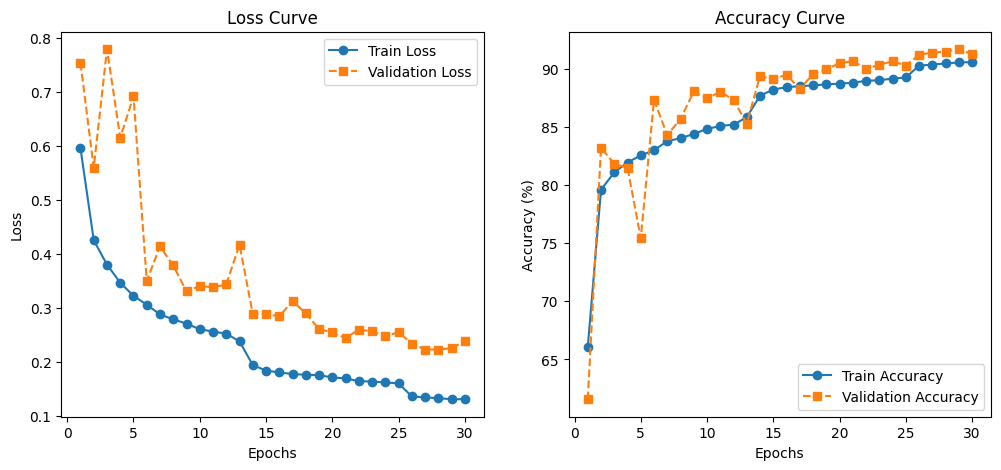

In [45]:
import matplotlib.pyplot as plt

# Data from your training log
epochs = list(range(1, 31))  # Assuming 30 epochs
train_losses = [0.5952, 0.4249, 0.3798, 0.3462, 0.3221, 0.3055, 0.2877, 0.2784, 0.2706, 0.2601, 0.2560, 
                0.2521, 0.2377, 0.1940, 0.1837, 0.1803, 0.1773, 0.1760, 0.1753, 0.1710, 0.1693,
                0.1642, 0.1634, 0.1618, 0.1600, 0.1360, 0.1340, 0.1327, 0.1307, 0.1308]

val_losses = [0.7530, 0.5589, 0.7784, 0.6147, 0.6911, 0.3494, 0.4135, 0.3782, 0.3303, 0.3404, 0.3378, 
              0.3431, 0.4167, 0.2887, 0.2885, 0.2840, 0.3121, 0.2899, 0.2605, 0.2544, 0.2436,
              0.2596, 0.2564, 0.2470, 0.2548, 0.2336, 0.2226, 0.2227, 0.2253, 0.2378]

train_accuracies = [66.05, 79.59, 81.08, 81.93, 82.55, 82.98, 83.77, 84.02, 84.39, 84.82, 85.07, 
                    85.19, 85.82, 87.68, 88.20, 88.41, 88.49, 88.56, 88.64, 88.72, 88.78,
                    88.96, 89.00, 89.15, 89.24, 90.26, 90.35, 90.45, 90.53, 90.56]

val_accuracies = [61.58, 83.20, 81.82, 81.47, 75.41, 87.30, 84.29, 85.67, 88.04, 87.44, 88.01, 
                  87.32, 85.28, 89.36, 89.08, 89.49, 88.25, 89.53, 89.95, 90.46, 90.65,
                  90.00, 90.33, 90.64, 90.27, 91.19, 91.38, 91.46, 91.67, 91.25]

# Plot loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", marker="o", linestyle="-")
plt.plot(epochs, val_losses, label="Validation Loss", marker="s", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy", marker="o", linestyle="-")
plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker="s", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy Curve")

plt.show()


In [49]:
import numpy as np

y_true = []
y_scores = []

model.eval()
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to("cuda"), y_batch.to("cuda")
        outputs = model(X_batch)  # Raw model outputs
        probs = torch.softmax(outputs, dim=1)  # Convert to probabilities

        y_true.extend(y_batch.cpu().numpy())  # True labels
        y_scores.extend(probs.cpu().numpy())  # Probabilities for each class


['Bots' 'Brute Force' 'DDoS' 'DoS' 'Normal Traffic' 'Port Scanning'
 'Web Attacks']


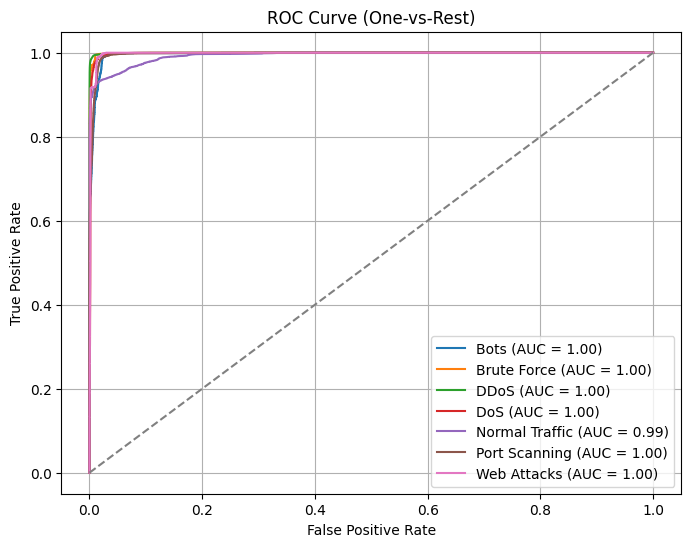

In [52]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class (One-vs-Rest)
n_classes = len(set(y_true))  # Number of classes
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))  # Convert to binary format

class_names = label_encoder.classes_
print(class_names)

# Compute ROC Curve & AUC for each class
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], np.array(y_scores)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend()
plt.grid()
plt.show()


c:\PythonProjects\PBL2\pbl\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


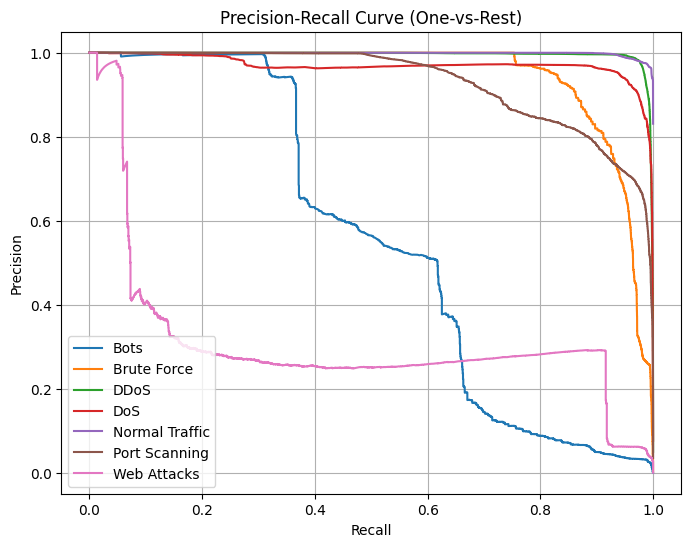

In [53]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(8, 6))
for i, class_name in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], np.array(y_scores)[:, i])
    plt.plot(recall, precision, label=class_name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (One-vs-Rest)")
plt.legend()
plt.grid()
plt.show()
